In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    #total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss*modulating_number
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0616/weights_KD_segformer_0616_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.3
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.0965

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 531ms/step - loss: 0.0798
Average validation loss: 0.5399489402770996
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 541ms/step - loss: 0.0798 - val_loss: 0.5399
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 501ms/step - loss: 0.0587 - val_loss: 0.5399
Average validation loss: 0.5396293997764587
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 510ms/step - loss: 0.0587 - val_loss: 0.5398
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 539ms/step - loss: 0.0448 - val_loss: 0.5398
Average validation loss: 0.26718559861183167
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 552ms/step - loss: 0.0448 - val_loss: 0.4489
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segf

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 841ms/step - loss: 1.7551e-05
Average validation loss: 0.06087648868560791
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 851ms/step - loss: 1.7551e-05 - val_loss: 0.0609
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 807ms/step - loss: 1.7011e-05 - val_loss: 0.0609
Average validation loss: 0.06274520419538021
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 820ms/step - loss: 1.7011e-05 - val_loss: 0.0618
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 802ms/step - loss: 1.6100e-05 - val_loss: 0.0618
Average validation loss: 0.03886856511235237
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 817ms/step - loss: 1.6100e-05 - val_loss: 0.0542
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_10.pth'.
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 778ms/step - loss: 1.6163e-05 - val_loss: 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 817ms/step - loss: 4.7418e-06
Average validation loss: 0.012266930192708969
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 826ms/step - loss: 4.7418e-06 - val_loss: 0.0123
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 818ms/step - loss: 4.4636e-06 - val_loss: 0.0123
Average validation loss: 0.011381418133775393
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 833ms/step - loss: 4.4636e-06 - val_loss: 0.0118
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_15.pth'.
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 29s 769ms/step - loss: 4.1998e-06 - val_loss: 0.0118
Average validation loss: 0.012464332859963179
12/12 ━━━━━━━━━━━━━━━━━━━━ 29s 785ms/step - loss: 4.1998e-06 - val_loss: 0.0120
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 39s 787ms/step - loss: 3.98

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 864ms/step - loss: 5.2120e-06
Average validation loss: 0.007646884769201279
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 877ms/step - loss: 5.2120e-06 - val_loss: 0.0076
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 795ms/step - loss: 4.4372e-06 - val_loss: 0.0076
Average validation loss: 0.008809449966065586
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 810ms/step - loss: 4.4372e-06 - val_loss: 0.0082
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 803ms/step - loss: 3.9686e-06 - val_loss: 0.0082
Average validation loss: 0.017124273348599672
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 816ms/step - loss: 3.9686e-06 - val_loss: 0.0112
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 53s 801ms/step - loss: 3.5641e-06 - val_loss: 0.0112
Average validation loss: 0.007819254649803042
16/16 ━━━━━━━━━━━━━━━━━━━━ 53s 816ms/step - loss: 3.5641e-06 - val_loss: 0.0103
Epoch

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 828ms/step - loss: 3.7131e-06
Average validation loss: 0.013187482953071594
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 838ms/step - loss: 3.7131e-06 - val_loss: 0.0132
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 810ms/step - loss: 2.9242e-06 - val_loss: 0.0132
Average validation loss: 0.006472709146328271
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 820ms/step - loss: 2.9242e-06 - val_loss: 0.0098
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_25.pth'.
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 812ms/step - loss: 2.5296e-06 - val_loss: 0.0098
Average validation loss: 0.0046569403726607565
20/20 ━━━━━━━━━━━━━━━━━━━━ 50s 823ms/step - loss: 2.5296e-06 - val_loss: 0.0081
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 812ms/step - loss: 1.7788e-06
Average validation loss: 0.004743898714271684
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 822ms/step - loss: 1.7788e-06 - val_loss: 0.0047
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 807ms/step - loss: 1.3283e-06 - val_loss: 0.0047
Average validation loss: 0.003578042301038901
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 817ms/step - loss: 1.3283e-06 - val_loss: 0.0042
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_30.pth'.
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 59s 808ms/step - loss: 1.1455e-06 - val_loss: 0.0042
Average validation loss: 0.002755021268967539
24/24 ━━━━━━━━━━━━━━━━━━━━ 59s 818ms/step - loss: 1.1455e-06 - val_loss: 0.0037
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 35s 872ms/step - loss: 5.4401e-06
Average validation loss: 0.019667131104506554
40/40 ━━━━━━━━━━━━━━━━━━━━ 35s 885ms/step - loss: 5.4401e-06 - val_loss: 0.0197
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 68s 806ms/step - loss: 3.8850e-06 - val_loss: 0.0197
Average validation loss: 0.015670455677900465
40/40 ━━━━━━━━━━━━━━━━━━━━ 68s 820ms/step - loss: 3.8850e-06 - val_loss: 0.0177
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_50.pth'.
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 101s 815ms/step - loss: 3.0867e-06 - val_loss: 0.0177
Average validation loss: 0.015866432141046972
40/40 ━━━━━━━━━━━━━━━━━━━━ 101s 827ms/step - loss: 3.0867e-06 - val_loss: 0.0171
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 133s 804ms/step - loss: 2

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 40s 827ms/step - loss: 3.0555e-06
Average validation loss: 0.005130679501841466
48/48 ━━━━━━━━━━━━━━━━━━━━ 40s 839ms/step - loss: 3.0555e-06 - val_loss: 0.0051
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 80s 829ms/step - loss: 2.2401e-06 - val_loss: 0.0051
Average validation loss: 0.008537773411565771
48/48 ━━━━━━━━━━━━━━━━━━━━ 81s 841ms/step - loss: 2.2401e-06 - val_loss: 0.0068
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 121s 830ms/step - loss: 1.8672e-06 - val_loss: 0.0068
Average validation loss: 0.0037729139633787176
48/48 ━━━━━━━━━━━━━━━━━━━━ 121s 842ms/step - loss: 1.8672e-06 - val_loss: 0.0058
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_60.pth'.
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 161s 832ms/step - loss: 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 45s 794ms/step - loss: 4.1898e-06
Average validation loss: 0.0181117314745539
56/56 ━━━━━━━━━━━━━━━━━━━━ 45s 806ms/step - loss: 4.1898e-06 - val_loss: 0.0181
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 89s 788ms/step - loss: 3.0237e-06 - val_loss: 0.0181
Average validation loss: 0.005710491320184831
56/56 ━━━━━━━━━━━━━━━━━━━━ 90s 799ms/step - loss: 3.0237e-06 - val_loss: 0.0119
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_70.pth'.
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 135s 795ms/step - loss: 2.4459e-06 - val_loss: 0.0119
Average validation loss: 0.011877104041299649
56/56 ━━━━━━━━━━━━━━━━━━━━ 135s 807ms/step - loss: 2.4459e-06 - val_loss: 0.0119
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 182s 824ms/step - loss: 2.0

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 52s 803ms/step - loss: 1.2204e-06
Average validation loss: 0.01824818755267188
64/64 ━━━━━━━━━━━━━━━━━━━━ 52s 814ms/step - loss: 1.2204e-06 - val_loss: 0.0182
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 102s 778ms/step - loss: 9.5078e-07 - val_loss: 0.0182
Average validation loss: 0.0021846637537237257
64/64 ━━━━━━━━━━━━━━━━━━━━ 103s 790ms/step - loss: 9.5078e-07 - val_loss: 0.0102
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_80.pth'.
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 153s 777ms/step - loss: 7.8974e-07 - val_loss: 0.0102
Average validation loss: 0.01506818518100772
64/64 ━━━━━━━━━━━━━━━━━━━━ 153s 788ms/step - loss: 7.8974e-07 - val_loss: 0.0118
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 203s 776ms/step - loss: 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 56s 777ms/step - loss: 1.1078e-05
Average validation loss: 0.010091946731942395
72/72 ━━━━━━━━━━━━━━━━━━━━ 57s 788ms/step - loss: 1.1078e-05 - val_loss: 0.0101
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 113s 776ms/step - loss: 8.5304e-06 - val_loss: 0.0101
Average validation loss: 0.03797980206501153
72/72 ━━━━━━━━━━━━━━━━━━━━ 113s 787ms/step - loss: 8.5304e-06 - val_loss: 0.0240
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 169s 775ms/step - loss: 7.0100e-06 - val_loss: 0.0240
Average validation loss: 0.006426939255713175
72/72 ━━━━━━━━━━━━━━━━━━━━ 170s 786ms/step - loss: 7.0100e-06 - val_loss: 0.0182
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_90.pth'.
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 226s 782ms/step - loss: 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 62s 773ms/step - loss: 8.8247e-07
Average validation loss: 0.0077341772383078934
80/80 ━━━━━━━━━━━━━━━━━━━━ 63s 784ms/step - loss: 8.8247e-07 - val_loss: 0.0077
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 125s 774ms/step - loss: 7.1719e-07 - val_loss: 0.0077
Average validation loss: 0.0031600849004462363
80/80 ━━━━━━━━━━━━━━━━━━━━ 125s 785ms/step - loss: 7.1719e-07 - val_loss: 0.0054
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_100.pth'.
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 194s 854ms/step - loss: 5.7432e-07 - val_loss: 0.0054
Average validation loss: 0.006514822307508439
80/80 ━━━━━━━━━━━━━━━━━━━━ 195s 865ms/step - loss: 5.7432e-07 - val_loss: 0.0058
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 257s 783ms/step - l

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 76s 789ms/step - loss: 1.6304e-05
Average validation loss: 0.011424891325683953
96/96 ━━━━━━━━━━━━━━━━━━━━ 77s 801ms/step - loss: 1.6304e-05 - val_loss: 0.0114
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 151s 773ms/step - loss: 9.2110e-06 - val_loss: 0.0114
Average validation loss: 0.010863637566217221
96/96 ━━━━━━━━━━━━━━━━━━━━ 152s 784ms/step - loss: 9.2110e-06 - val_loss: 0.0111
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_120.pth'.
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 226s 772ms/step - loss: 6.4346e-06 - val_loss: 0.0111
Average validation loss: 0.011114991071129529
96/96 ━━━━━━━━━━━━━━━━━━━━ 228s 784ms/step - loss: 6.4346e-06 - val_loss: 0.0111
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 302s 773ms/step - los

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 94s 782ms/step - loss: 7.5745e-06
Average validation loss: 0.10042210991183917
120/120 ━━━━━━━━━━━━━━━━━━━━ 95s 794ms/step - loss: 7.5745e-06 - val_loss: 0.1004
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 188s 776ms/step - loss: 5.5341e-06 - val_loss: 0.1004
Average validation loss: 0.01860545916473105
120/120 ━━━━━━━━━━━━━━━━━━━━ 190s 787ms/step - loss: 5.5341e-06 - val_loss: 0.0595
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_150.pth'.
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 283s 779ms/step - loss: 4.3261e-06 - val_loss: 0.0595
Average validation loss: 0.04459146538261981
120/120 ━━━━━━━━━━━━━━━━━━━━ 285s 790ms/step - loss: 4.3261e-06 - val_loss: 0.0545
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 378s 777ms

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 112s 778ms/step - loss: 3.7273e-06
Average validation loss: 0.01071219315377271
144/144 ━━━━━━━━━━━━━━━━━━━━ 114s 789ms/step - loss: 3.7273e-06 - val_loss: 0.0107
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 225s 772ms/step - loss: 2.5652e-06 - val_loss: 0.0107
Average validation loss: 0.013265574991237372
144/144 ━━━━━━━━━━━━━━━━━━━━ 226s 783ms/step - loss: 2.5652e-06 - val_loss: 0.0120
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 338s 772ms/step - loss: 2.0430e-06 - val_loss: 0.0120
Average validation loss: 0.013330907842221981
144/144 ━━━━━━━━━━━━━━━━━━━━ 339s 783ms/step - loss: 2.0430e-06 - val_loss: 0.0124
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 450s 772ms/step - loss: 1.7264e-06 - val_loss: 0.0124
Average validation loss: 0.00969319773462808
144/144 ━━━━━━━━━━━━━━━━━━━━ 452s 783ms/step - loss: 1.7264e-06 -

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 124s 774ms/step - loss: 3.4923e-06
Average validation loss: 0.008421286646625958
160/160 ━━━━━━━━━━━━━━━━━━━━ 125s 784ms/step - loss: 3.4923e-06 - val_loss: 0.0084
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 255s 811ms/step - loss: 2.5099e-06 - val_loss: 0.0084
Average validation loss: 0.018084914670907892
160/160 ━━━━━━━━━━━━━━━━━━━━ 257s 821ms/step - loss: 2.5099e-06 - val_loss: 0.0133
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 382s 783ms/step - loss: 1.9571e-06 - val_loss: 0.0133
Average validation loss: 0.0054182865394977854
160/160 ━━━━━━━━━━━━━━━━━━━━ 384s 794ms/step - loss: 1.9571e-06 - val_loss: 0.0106
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_200.pth'.
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 509s

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 154s 771ms/step - loss: 2.1585e-06
Average validation loss: 0.011964785348709484
200/200 ━━━━━━━━━━━━━━━━━━━━ 156s 783ms/step - loss: 2.1585e-06 - val_loss: 0.0120
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 311s 772ms/step - loss: 1.7660e-06 - val_loss: 0.0120
Average validation loss: 0.007597215102141491
200/200 ━━━━━━━━━━━━━━━━━━━━ 313s 782ms/step - loss: 1.7660e-06 - val_loss: 0.0098
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_250.pth'.
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 469s 778ms/step - loss: 1.4293e-06 - val_loss: 0.0098
Average validation loss: 0.005115439580840757
200/200 ━━━━━━━━━━━━━━━━━━━━ 471s 789ms/step - loss: 1.4293e-06 - val_loss: 0.0082
Saved model weights to 'c:\天_11157065\git\Rip

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 187s 779ms/step - loss: 2.8433e-06
Average validation loss: 0.009219834123117228
240/240 ━━━━━━━━━━━━━━━━━━━━ 190s 790ms/step - loss: 2.8433e-06 - val_loss: 0.0092
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 375s 769ms/step - loss: 2.0124e-06 - val_loss: 0.0092
Average validation loss: 0.005272832727738811
240/240 ━━━━━━━━━━━━━━━━━━━━ 377s 780ms/step - loss: 2.0124e-06 - val_loss: 0.0072
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_300.pth'.
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 562s 771ms/step - loss: 1.6205e-06 - val_loss: 0.0072
Average validation loss: 0.0058964191211998696
240/240 ━━━━━━━━━━━━━━━━━━━━ 565s 782ms/step - loss: 1.6205e-06 - val_loss: 0.0068
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 749s

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.10768260594457388, 0.03023492600535974, 0.013028299196933707, 0.006436189130472485, 0.0039016748000867663, 0.0036427189522267632, 0.044667161155375654, 0.04487079440315331, 0.017807178985094655, 0.01927659518783912, 0.010549551173527207, 0.0057504818702582275, 0.017932222605159042, 0.021748004026384972, 0.017538932835485764, 0.012675197858564406, 0.0073711721923225846, 0.005268563890533159]
std_val_losses =  [0.10861170660511381, 0.025966827048731135, 0.01908844244490769, 0.003561855107201303, 0.0017096637659324073, 0.0026243122982101182, 0.12109897443290701, 0.0727137941255993, 0.021084768305878406, 0.03335352671736726, 0.012639679542152667, 0.009396086701016947, 0.03693684085735406, 0.023077374853793377, 0.010766353553929593, 0.014326539453174946, 0.004424458412953886, 0.0018113857740347196]


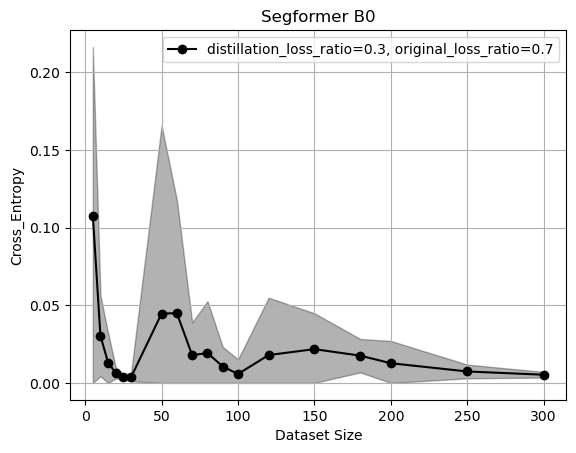

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0616')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.png"))

plt.show()